## 0.0. Импортирование необходимых библиотек

In [199]:
import glob
import os
import random
import zipfile
from collections import Counter

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import models
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
import torchvision.utils as vutils
from tqdm import tqdm

## 0.1. Выгрузка данных

In [2]:
zip_path = "dl-2025-competition-1.zip"
extract_dir = "data"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

## 1. Анализ данных

Напишем простой кастомный датасет, который будет подстроен под структуру наших данных и посмотрим на то, с чем мы имеем дело

In [3]:
class FirstDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []

        all_classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(all_classes)}
        self.idx_to_class = {
            idx: cls_name for cls_name, idx in self.class_to_idx.items()
        }

        for cls_name in all_classes:
            class_path = os.path.join(root_dir, cls_name)
            if not os.path.isdir(class_path):
                continue
            files = sorted(glob.glob(os.path.join(class_path, "*.png")))

            for file_path in files:
                self.samples.append((file_path, self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Не удалось загрузить изображение: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

In [4]:
train_dataset = FirstDataset(
    root_dir="data/data/train", transform=transforms.ToTensor()
)

Посмотрим на распределение изображений по классам, чтобы определить на глаз есть ли у нас дисбаланс классов.

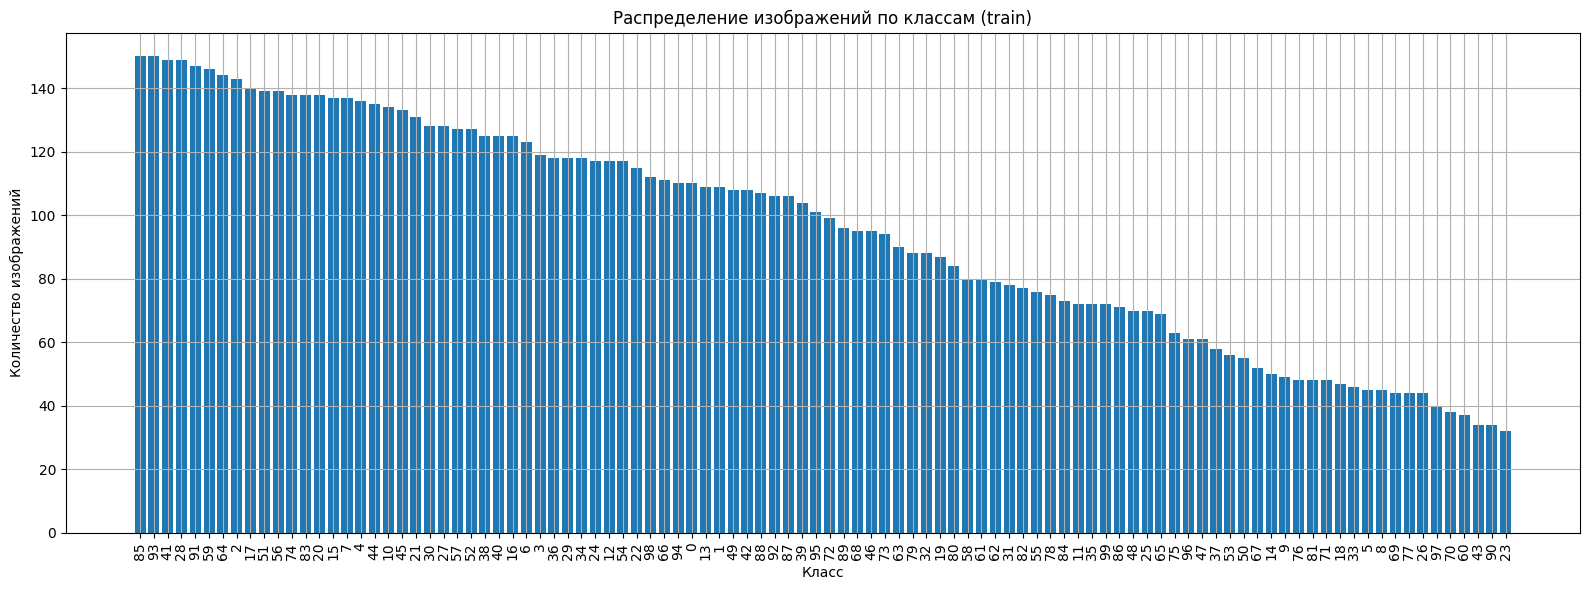

In [5]:
labels = [label for _, label in train_dataset]

class_counts = Counter(labels)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
class_names = [idx_to_class[i] for i in class_counts.keys()]

df = pd.DataFrame(
    {"class": class_names, "count": list(class_counts.values())}
).sort_values(by="count", ascending=False)

plt.figure(figsize=(16, 6))
plt.bar(df["class"], df["count"])
plt.xticks(rotation=90)
plt.title("Распределение изображений по классам (train)")
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.grid(True)
plt.tight_layout()
plt.show()

In [158]:
print(f" Самый частый класс: '{df.iloc[0]['class']}' с количеством изображений: {df.iloc[0]['count']}")
print(f" Самый редкий класс: '{df.iloc[-1]['class']}' с количеством изображений: {df.iloc[-1]['count']}")

 Самый частый класс: '85' с количеством изображений: 150
 Самый редкий класс: '23' с количеством изображений: 32


Как видим диабаланс в наших данных присутсвует. В самом популярном классе количество изображений  почти в 5 раз больше, чем в самом непопулярном.

Посмотрим что вообще лежит в нашем датасете, выведем по одной картинке для 10 рандомных классов:

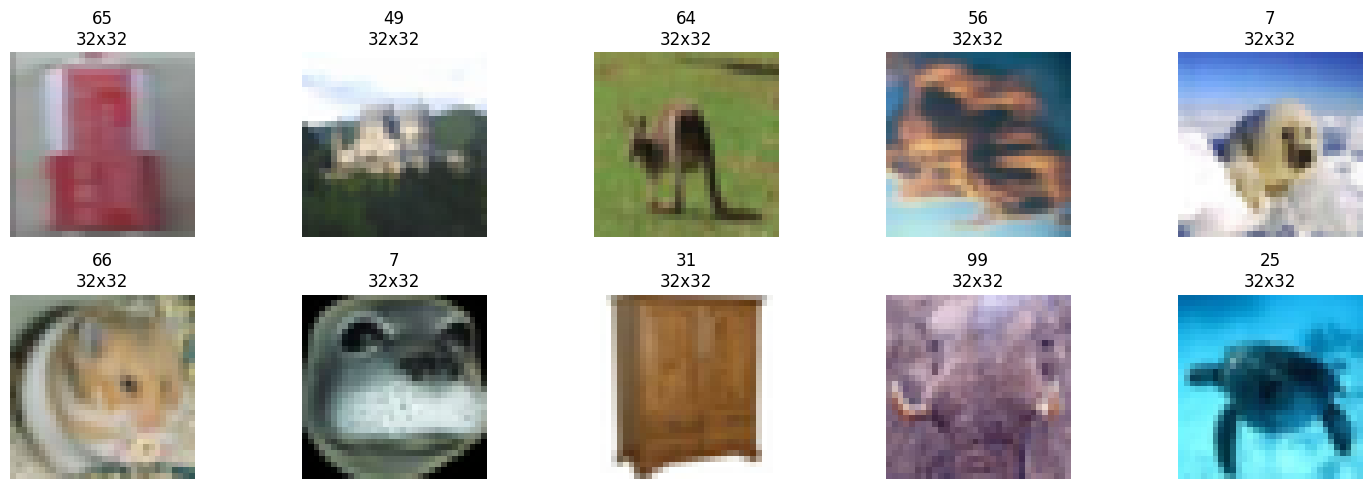

In [9]:
def random_images(dataset, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        class_name = list(dataset.class_to_idx.keys())[
            list(dataset.class_to_idx.values()).index(label)
        ]
        image_np = image.permute(1, 2, 0).numpy()
        height, width = image_np.shape[:2]

        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(image_np)
        plt.title(f"{class_name}\n{width}x{height}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


random_images(train_dataset, num_images=10)

Как видим, картинки у нас маленького размера (32 * 32), что может затруднять извлечение сложных признаков.  Скорее всего лучше будет использовать предобученные модели, которые способны компенсировать низкое качество исходных данных за счёт ранее извлечённых признаков. Возможно не нужно использовать слишком грубую аугментацию, но использовать её точно стоит, потому что она может бороться с переобучением, особенно при дисбалансе классов, который у нас ярко выражен. Но это пока всего лишь предположения, будем проверять на деле :)



## 2. Аугментационный пайплайн

Так как в следующем задании от нас требуеется протестировать модель с новороченными аугментациями и без новороченных, напишем два пайплайна, которые потом будем прогружать в модели

#### 2.1. НЕнавороченный пайплайн

Не будем добавлять ничего лишнего, только **HorizontalFlip** (не портит смысл изображения); **Rotate(limit=10, p=0.5)** - угол 10° — безопасный для мелких изображений, не размывает объекты; **ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, p=0.3),** чтобы модель была устойчивой к изменениям освещения и цветовой палитры. В общем, только мягкие методы.

In [42]:
easy_transforms = {
    "train": A.Compose(
        [
            A.Resize(224, 224, interpolation=1, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=20, p=0.5),
            A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, p=0.3),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    ),
    "test": A.Compose(
        [
            A.Resize(224, 224),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    ),
}

#### 2.2. Навороченный пайплайн

Добавим **ShiftScaleRotate**, чтобы модель была инвариантной к положению и ориентации объектов; **VerticalFlip**; **RandomShadow** - добавляет тени на изображение; **A.OneOf** -искажения помогают модели не "запоминать" пиксели, а учиться видеть структуру объекта; **ToGray** - в ч/б, **RandomBrightnessContrast** сильные изменения яркости и контраста

In [56]:
hard_transforms = {
    "train": A.Compose(
        [
            A.Resize(224, 224, interpolation=1, p=1.0),
            A.ShiftScaleRotate(
                shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5
            ),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ColorJitter(
                brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05, p=0.5
            ),
            A.RandomShadow(p=0.15),
            A.OneOf(
                [
                    A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.3),
                    A.GridDistortion(num_steps=3, distort_limit=0.05, p=0.3),
                    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=10, p=0.3),
                ],
                p=0.2,
            ),
            A.OneOf(
                [
                    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
                    A.MotionBlur(blur_limit=7, p=0.2),
                ],
                p=0.2,
            ),
            A.ToGray(p=0.1),
            A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.2),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    ),
    "test": A.Compose(
        [
            A.Resize(224, 224),
            A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
    ),
}

#### 2.3. Визуализация применения различных аугментаций

Тепеь создадим кастомный рабочий датасет, который будем использовать для обучения и для аугментации:

In [159]:
class MultiClassDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None, val_split=0.2):

        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        all_classes = sorted(os.listdir(root_dir))
        for idx, cls_name in enumerate(all_classes):
            cls_path = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_path):
                continue

            self.class_to_idx[cls_name] = idx
            self.idx_to_class[idx] = cls_name

            files = sorted(glob.glob(os.path.join(cls_path, "*.png")))

            self.samples.extend([(f, idx) for f in files])

        np.random.shuffle(self.samples)

        split_idx = int((1 - val_split) * len(self.samples))
        if split == "train":
            self.samples = self.samples[:split_idx]
        else:
            self.samples = self.samples[split_idx:]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = cv2.imread(img_path)
        if image is None:
            print(f"Не удалось открыть изображение: {img_path}")
            new_idx = (idx + 1) % len(self.samples)
            return self.__getitem__(new_idx)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

In [58]:
# Пути к изображениям для train и test
root = "data/data/train"
test_dir = "data/data/test"

Посмотрим на наши **ненавороченные** и **навороченные** аугментации:

In [59]:
train_dataset = MultiClassDataset(
    split="train", root_dir=root, transform=easy_transforms["train"]
)
val_dataset = MultiClassDataset(
    split="val", root_dir=root, transform=easy_transforms["test"]
)

In [60]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = next(iter(train_loader))

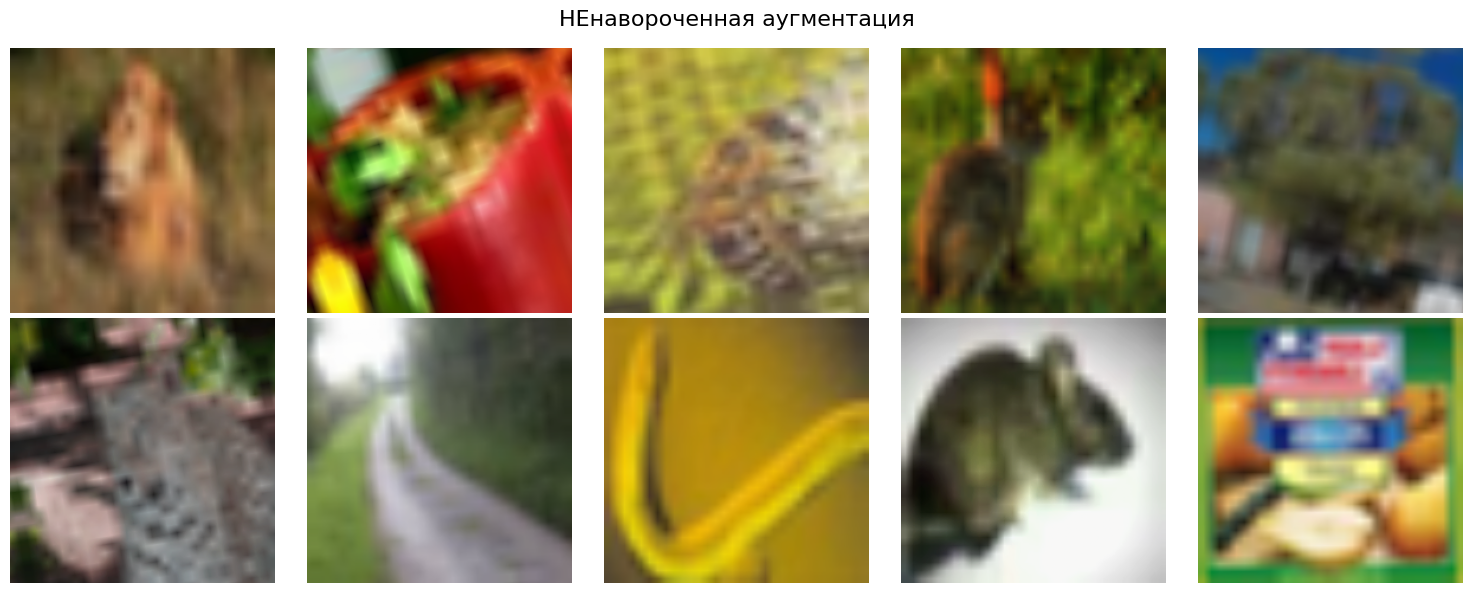

In [62]:
def denormalize_batch(batch, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    batch = batch.clone()
    for i in range(batch.shape[0]):
        for t, m, s in zip(batch[i], mean, std):
            t.mul_(s).add_(m)
    return torch.clamp(batch, 0, 1)


denorm_images = denormalize_batch(images)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(denorm_images[i].permute(1, 2, 0))
    ax.axis("off")

fig.suptitle("НЕнавороченная аугментация", fontsize=16)
plt.tight_layout()
plt.show()

In [63]:
train_dataset = MultiClassDataset(
    split="train", root_dir=root, transform=hard_transforms["train"]
)
val_dataset = MultiClassDataset(
    split="val", root_dir=root, transform=hard_transforms["test"]
)

In [64]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [65]:
images, labels = next(iter(train_loader))

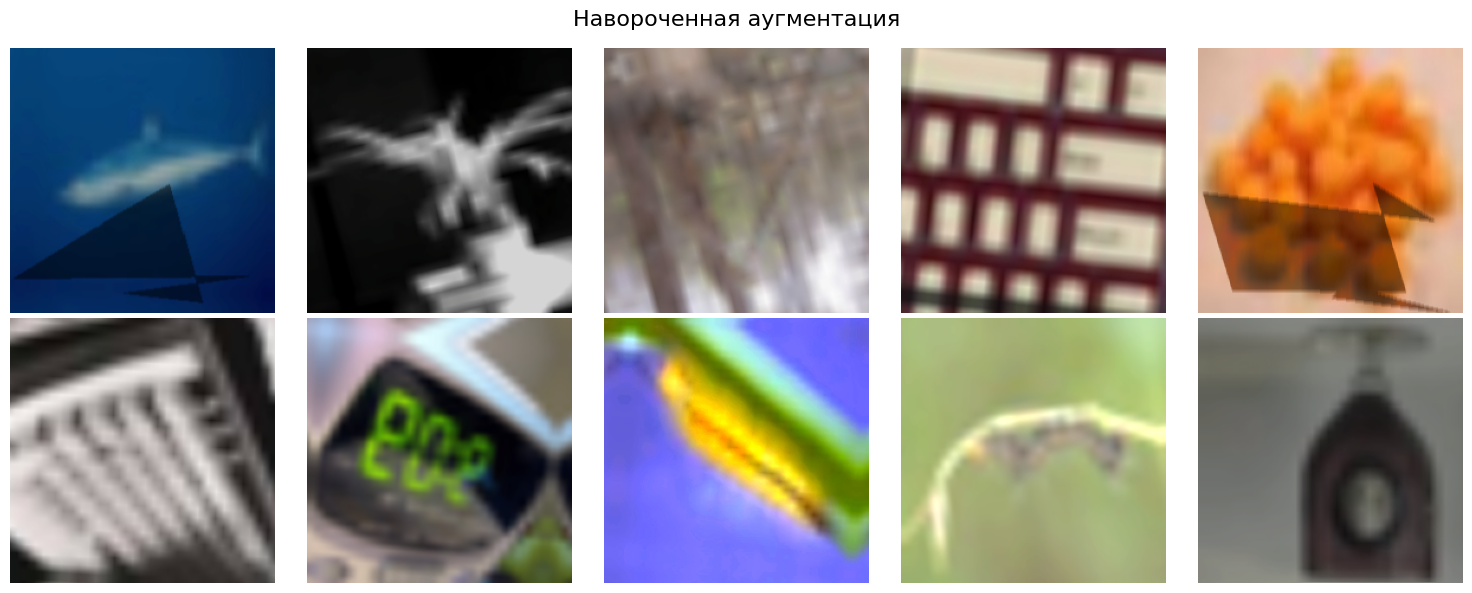

In [66]:
def denormalize_batch(batch, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    batch = batch.clone()
    for i in range(batch.shape[0]):
        for t, m, s in zip(batch[i], mean, std):
            t.mul_(s).add_(m)
    return torch.clamp(batch, 0, 1)


denorm_images = denormalize_batch(images)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(denorm_images[i].permute(1, 2, 0))
    ax.axis("off")

fig.suptitle("Навороченная аугментация", fontsize=16)
plt.tight_layout()
plt.show()

## 3. ОСНОВНАЯ ЧАСТЬ

### 3.1. Простая модель без transfer learning и с простой аугментацией

In [127]:
## Деление на train и validation

train_dataset = MultiClassDataset(split="train", root_dir=root, transform=easy_transforms["train"])
val_dataset = MultiClassDataset(split="val", root_dir=root, transform=easy_transforms["test"])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [123]:
class LightCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LightCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x16x16
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x8x8
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightCNN(in_channels=3, num_classes=100)
model = model.to(device)

In [125]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/20
Train Loss: 4.4683, Train Acc: 0.0308
Val Loss: 4.1493, Val Acc: 0.0568
Epoch 2/20
Train Loss: 4.1793, Train Acc: 0.0568
Val Loss: 3.8943, Val Acc: 0.1062
Epoch 3/20
Train Loss: 3.9939, Train Acc: 0.0845
Val Loss: 3.6378, Val Acc: 0.1640
Epoch 4/20
Train Loss: 3.8339, Train Acc: 0.1099
Val Loss: 3.4298, Val Acc: 0.1914
Epoch 5/20
Train Loss: 3.6715, Train Acc: 0.1368
Val Loss: 3.2811, Val Acc: 0.2408
Epoch 6/20
Train Loss: 3.5529, Train Acc: 0.1619
Val Loss: 3.1205, Val Acc: 0.2681
Epoch 7/20
Train Loss: 3.4090, Train Acc: 0.1828
Val Loss: 2.9715, Val Acc: 0.3002
Epoch 8/20
Train Loss: 3.2911, Train Acc: 0.2033
Val Loss: 2.8004, Val Acc: 0.3318
Epoch 9/20
Train Loss: 3.2130, Train Acc: 0.2165
Val Loss: 2.6004, Val Acc: 0.3644
Epoch 10/20
Train Loss: 3.1385, Train Acc: 0.2305
Val Loss: 2.5960, Val Acc: 0.3985
Epoch 11/20
Train Loss: 3.0159, Train Acc: 0.2532
Val Loss: 2.4833, Val Acc: 0.4238
Epoch 12/20
Train Loss: 2.9509, Train Acc: 0.2683
Val Loss: 2.3958, Val Acc: 0.4317
E

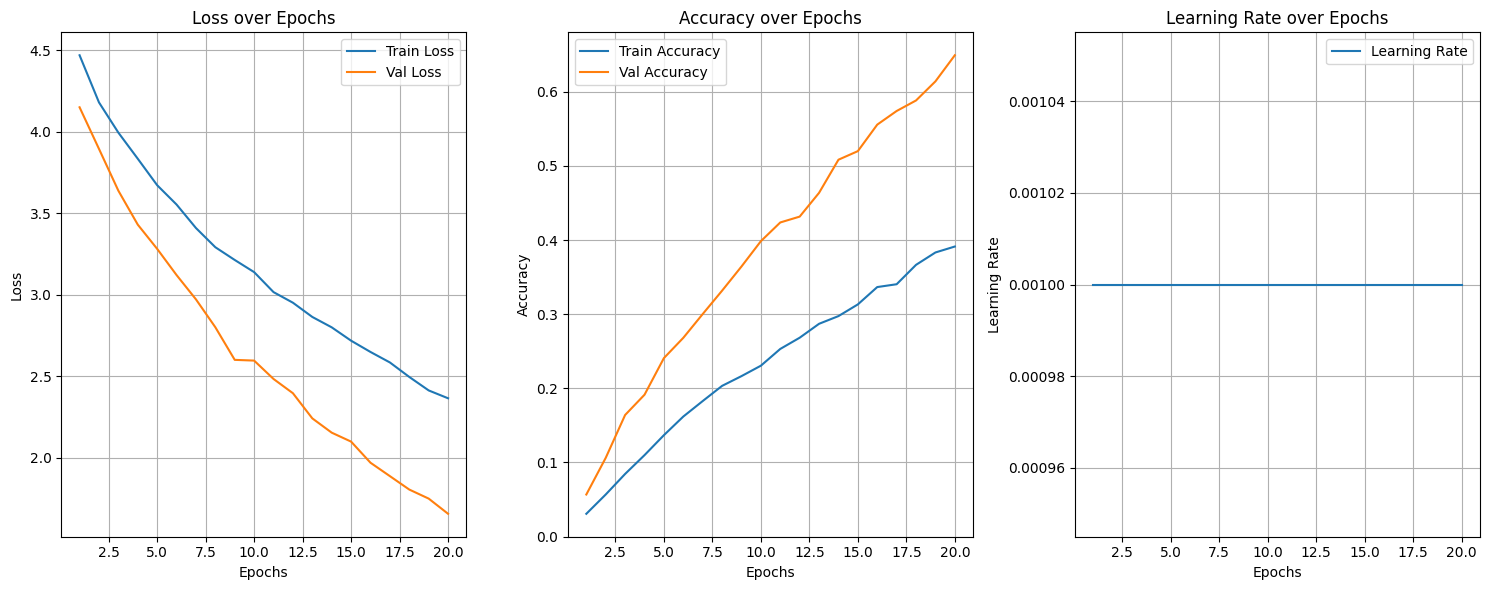

In [126]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
lr_history = []

num_epochs = 20
best_val_loss = float("inf")
patience = 3
patience_counter = 0

lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, verbose=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    lr_scheduler.step(val_epoch_loss)
    lr_history.append(optimizer.param_groups[0]["lr"])

model.load_state_dict(best_model_wts)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))


ax1.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
ax1.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
ax1.set_title("Loss over Epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)


ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy")
ax2.set_title("Accuracy over Epochs")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

ax3.plot(range(1, len(lr_history) + 1), lr_history, label="Learning Rate")
ax3.set_title("Learning Rate over Epochs")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Learning Rate")
ax3.legend()
ax3.grid(True)


plt.tight_layout()
plt.show()

### 3.2. Простая модель без transfer learning и со сложной аугментацией

In [160]:
train_dataset = MultiClassDataset(split="train", root_dir=root, transform=hard_transforms["train"])
val_dataset = MultiClassDataset(split="val", root_dir=root, transform=hard_transforms["test"])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [161]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightCNN(in_channels=3, num_classes=100)
model = model.to(device)

In [162]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/20
Train Loss: 4.5555, Train Acc: 0.0206
Val Loss: 4.3511, Val Acc: 0.0358
Epoch 2/20
Train Loss: 4.3513, Train Acc: 0.0390
Val Loss: 4.2355, Val Acc: 0.0568
Epoch 3/20
Train Loss: 4.2079, Train Acc: 0.0580
Val Loss: 3.9694, Val Acc: 0.0988
Epoch 4/20
Train Loss: 4.1198, Train Acc: 0.0733
Val Loss: 3.8174, Val Acc: 0.1094
Epoch 5/20
Train Loss: 4.0558, Train Acc: 0.0820
Val Loss: 3.7484, Val Acc: 0.1335
Epoch 6/20
Train Loss: 3.9921, Train Acc: 0.0917
Val Loss: 3.7592, Val Acc: 0.1309
Epoch 7/20
Train Loss: 3.9423, Train Acc: 0.0937
Val Loss: 3.6231, Val Acc: 0.1525
Epoch 8/20
Train Loss: 3.8956, Train Acc: 0.1034
Val Loss: 3.5503, Val Acc: 0.1661
Epoch 9/20
Train Loss: 3.8515, Train Acc: 0.1059
Val Loss: 3.5697, Val Acc: 0.1756
Epoch 10/20
Train Loss: 3.8216, Train Acc: 0.1166
Val Loss: 3.4911, Val Acc: 0.1830
Epoch 11/20
Train Loss: 3.7843, Train Acc: 0.1220
Val Loss: 3.4146, Val Acc: 0.1887
Epoch 12/20
Train Loss: 3.7581, Train Acc: 0.1207
Val Loss: 3.4289, Val Acc: 0.2045
E

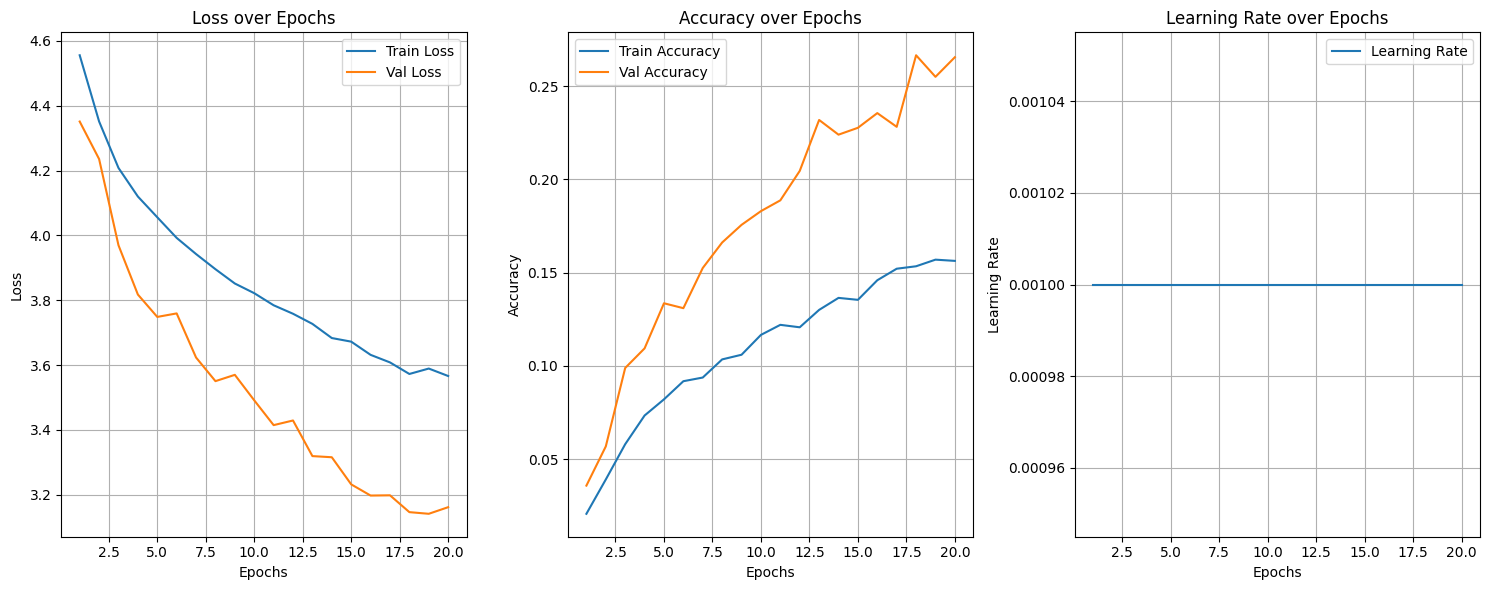

In [163]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
lr_history = []

num_epochs = 20
best_val_loss = float("inf")
patience = 3
patience_counter = 0

lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, verbose=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    lr_scheduler.step(val_epoch_loss)
    lr_history.append(optimizer.param_groups[0]["lr"])

model.load_state_dict(best_model_wts)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))


ax1.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
ax1.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
ax1.set_title("Loss over Epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)


ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy")
ax2.set_title("Accuracy over Epochs")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

ax3.plot(range(1, len(lr_history) + 1), lr_history, label="Learning Rate")
ax3.set_title("Learning Rate over Epochs")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Learning Rate")
ax3.legend()
ax3.grid(True)


plt.tight_layout()
plt.show()

Видим, что даже базовая модель справляется лучше с простой аугментацией, поэтому дальше от новоророченной откажемся. Но давайте посмотри, как наша моделька справляется без аугментации вовсе

### 3.3. Простая модель без transfer learning и без аугментации

In [164]:
class NO_AG_MultiClassDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, val_split=0.2):
        self.transform = transform if transform is not None else transforms.ToTensor()
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        all_classes = sorted(os.listdir(root_dir))
        for idx, cls_name in enumerate(all_classes):
            cls_path = os.path.join(root_dir, cls_name)
            if not os.path.isdir(cls_path):
                continue

            self.class_to_idx[cls_name] = idx
            self.idx_to_class[idx] = cls_name

            files = sorted(glob.glob(os.path.join(cls_path, '*.png')))
            self.samples.extend([(f, idx) for f in files])

        np.random.shuffle(self.samples)

        split_idx = int((1 - val_split) * len(self.samples))
        if split == 'train':
            self.samples = self.samples[:split_idx]
        else:
            self.samples = self.samples[split_idx:]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        image = cv2.imread(img_path)
        if image is None:
            print(f"Не удалось открыть изображение: {img_path}")
            new_idx = (idx + 1) % len(self.samples)
            return self.__getitem__(new_idx)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image) 

        if self.transform:
            image = self.transform(image)

        return image, label

In [165]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761])
])

In [166]:
train_dataset = NO_AG_MultiClassDataset(root_dir=root, split='train', transform=transform)
val_dataset = NO_AG_MultiClassDataset(root_dir=root, split='val', transform=transform)

In [167]:
train_loader = DataLoader(train_dataset,batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [168]:
model = LightCNN(in_channels=3, num_classes=100)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/20
Train Loss: 4.3957, Train Acc: 0.0367
Val Loss: 4.0153, Val Acc: 0.1009
Epoch 2/20
Train Loss: 3.9652, Train Acc: 0.0910
Val Loss: 3.5679, Val Acc: 0.1693
Epoch 3/20
Train Loss: 3.5913, Train Acc: 0.1491
Val Loss: 3.1284, Val Acc: 0.2624
Epoch 4/20
Train Loss: 3.2490, Train Acc: 0.2099
Val Loss: 2.6047, Val Acc: 0.3870
Epoch 5/20
Train Loss: 2.8182, Train Acc: 0.2946
Val Loss: 2.1629, Val Acc: 0.5163
Epoch 6/20
Train Loss: 2.2849, Train Acc: 0.3966
Val Loss: 1.7023, Val Acc: 0.6525
Epoch 7/20
Train Loss: 1.7543, Train Acc: 0.5227
Val Loss: 1.3587, Val Acc: 0.7240
Epoch 8/20
Train Loss: 1.3048, Train Acc: 0.6405
Val Loss: 1.1923, Val Acc: 0.7797
Epoch 9/20
Train Loss: 1.0120, Train Acc: 0.7073
Val Loss: 1.1508, Val Acc: 0.7992
Epoch 10/20
Train Loss: 0.8527, Train Acc: 0.7549
Val Loss: 1.1130, Val Acc: 0.8091
Epoch 11/20
Train Loss: 0.7012, Train Acc: 0.7969
Val Loss: 1.1288, Val Acc: 0.8149
Epoch 12/20
Train Loss: 0.5825, Train Acc: 0.8261
Val Loss: 1.1714, Val Acc: 0.8254
E

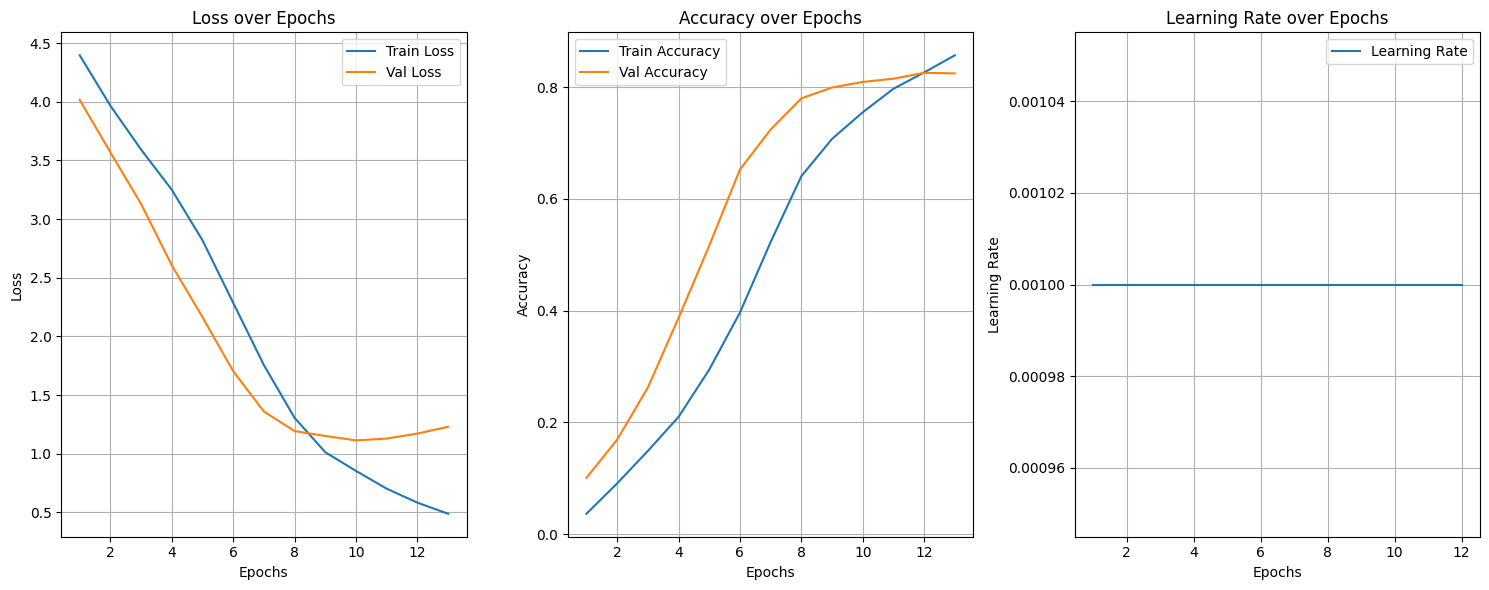

In [169]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
lr_history = []

num_epochs = 20
best_val_loss = float("inf")
patience = 3
patience_counter = 0

lr_scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, verbose=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)

    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    lr_scheduler.step(val_epoch_loss)
    lr_history.append(optimizer.param_groups[0]["lr"])

model.load_state_dict(best_model_wts)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))


ax1.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
ax1.plot(range(1, len(val_losses) + 1), val_losses, label="Val Loss")
ax1.set_title("Loss over Epochs")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)


ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Val Accuracy")
ax2.set_title("Accuracy over Epochs")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.grid(True)

ax3.plot(range(1, len(lr_history) + 1), lr_history, label="Learning Rate")
ax3.set_title("Learning Rate over Epochs")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Learning Rate")
ax3.legend()
ax3.grid(True)


plt.tight_layout()
plt.show()

Ситуация улучшилась, а это только 20 эпох. Поэтому потенциал у модельки есть!

Но давайте посмотрим на модельки с transfer_learning. Рассмотрим три модели: **Efficientnet_b3**, **ViT-B/16**, **ViT-Large**

### 3.4. Efficientnet_b3 + НЕнавороченная аугментация

In [170]:
train_dataset = MultiClassDataset(split="train", root_dir=root, transform=easy_transforms["train"])
val_dataset = MultiClassDataset(split="val", root_dir=root, transform=easy_transforms["test"])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [171]:
class Image100(nn.Module):
    def __init__(self, backbone, head):
        super(Image100, self).__init__()
        self.backbone = backbone  # оставляем весь backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.head = head

    def forward(self, x):
        x = self.backbone.forward_features(x)  # используем timm-style
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x

In [174]:
backbone = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
for param in backbone.parameters():
    param.requires_grad = False
num_features = backbone.num_features 

head = nn.Sequential(
    nn.Dropout(p=0.25, inplace=True),
    nn.Linear(num_features, num_classes)
)
model = Image100(backbone, head)

In [175]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
          Identity-2         [-1, 40, 112, 112]               0
              SiLU-3         [-1, 40, 112, 112]               0
    BatchNormAct2d-4         [-1, 40, 112, 112]              80
            Conv2d-5         [-1, 40, 112, 112]             360
          Identity-6         [-1, 40, 112, 112]               0
              SiLU-7         [-1, 40, 112, 112]               0
    BatchNormAct2d-8         [-1, 40, 112, 112]              80
          Identity-9         [-1, 40, 112, 112]               0
           Conv2d-10             [-1, 10, 1, 1]             410
             SiLU-11             [-1, 10, 1, 1]               0
           Conv2d-12             [-1, 40, 1, 1]             440
          Sigmoid-13             [-1, 40, 1, 1]               0
    SqueezeExcite-14         [-1, 40, 1

In [176]:
# Начнём учитывать дисбаланс классов

train_labels = [label for _, label in train_dataset.samples]
class_counts = Counter(train_labels)

num_classes = len(train_dataset.class_to_idx)

class_weights = []
total_samples = sum(class_counts.values())
for i in range(num_classes):
    count = class_counts.get(i, 0)
    if count == 0:
        weight = 0
    else:
        weight = total_samples / (num_classes * count)
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)

In [177]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/30
Train Loss: 4.4414, Train Acc: 0.1015
Val Loss: 4.2035, Val Acc: 0.3428
Epoch 2/30
Train Loss: 4.0728, Train Acc: 0.3164
Val Loss: 3.8490, Val Acc: 0.4832
Epoch 3/30
Train Loss: 3.7686, Train Acc: 0.4051
Val Loss: 3.5431, Val Acc: 0.5384
Epoch 4/30
Train Loss: 3.5079, Train Acc: 0.4381
Val Loss: 3.2691, Val Acc: 0.5647
Epoch 5/30
Train Loss: 3.2718, Train Acc: 0.4667
Val Loss: 3.0123, Val Acc: 0.5889
Epoch 6/30
Train Loss: 3.0555, Train Acc: 0.4832
Val Loss: 2.8320, Val Acc: 0.6020
Epoch 7/30
Train Loss: 2.9017, Train Acc: 0.4993
Val Loss: 2.6490, Val Acc: 0.6094
Epoch 8/30
Train Loss: 2.7611, Train Acc: 0.5032
Val Loss: 2.5011, Val Acc: 0.6078
Epoch 9/30
Train Loss: 2.6280, Train Acc: 0.5127
Val Loss: 2.3455, Val Acc: 0.6220
Epoch 10/30
Train Loss: 2.5230, Train Acc: 0.5204
Val Loss: 2.2432, Val Acc: 0.6314
Epoch 11/30
Train Loss: 2.4088, Train Acc: 0.5322
Val Loss: 2.1190, Val Acc: 0.6504
Epoch 12/30
Train Loss: 2.3482, Train Acc: 0.5351
Val Loss: 2.0444, Val Acc: 0.6404
E

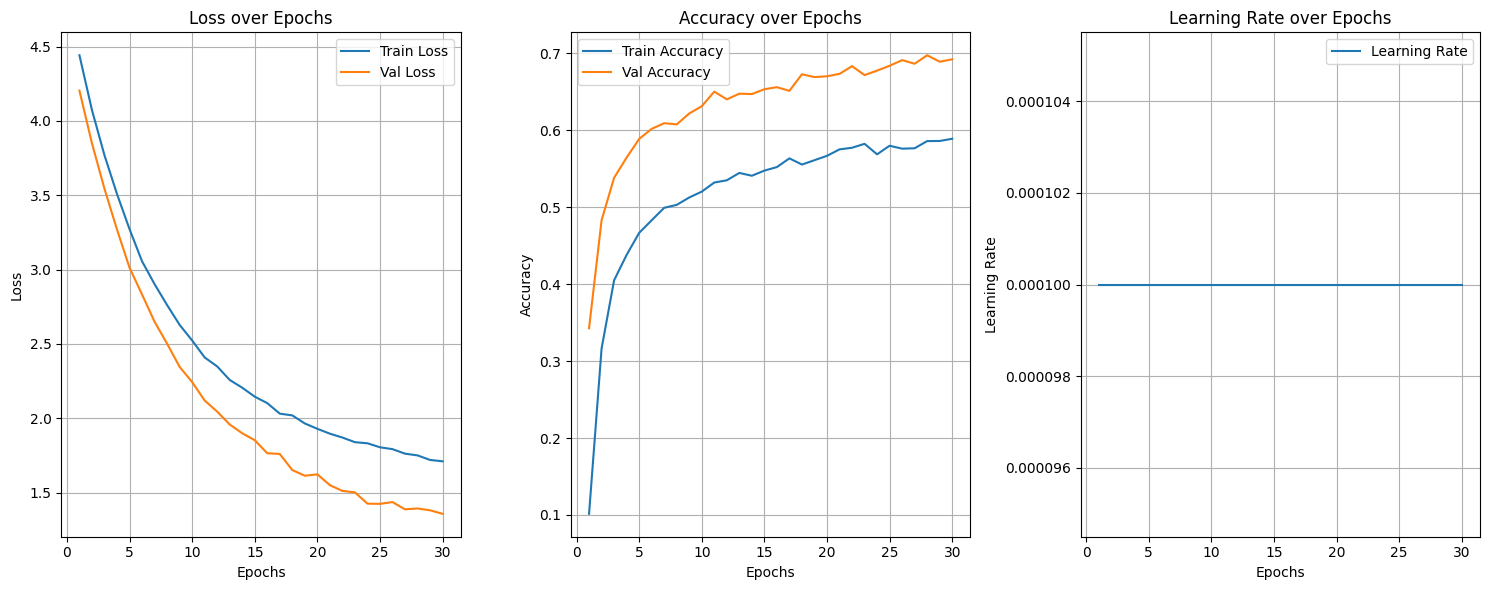

In [178]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
lr_history = []

num_epochs = 30
best_val_loss = float('inf')
patience = 3
patience_counter = 0

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    model.train() 
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  
        
        # Прямой проход
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 
        loss = criterion(outputs, labels) 
        
        loss.backward() 
        optimizer.step()  
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    
    model.eval() 
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad(): 
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
    
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())
    
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    
    if val_epoch_loss < best_val_loss: 
        best_val_loss = val_epoch_loss
        best_model_wts = model.state_dict()  
        patience_counter = 0 
    else:
        patience_counter += 1  
        if patience_counter >= patience: 
            print("Early stopping triggered.")
            break  # Прерываем обучение

    # Шаг scheduler-а
    lr_scheduler.step(val_epoch_loss)
    lr_history.append(optimizer.param_groups[0]['lr'])
    
model.load_state_dict(best_model_wts)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

ax3.plot(range(1, len(lr_history) + 1), lr_history, label='Learning Rate')
ax3.set_title('Learning Rate over Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Learning Rate')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

Справилась хуже, чем наша простенькая модель без аугментации, продолжаем....

### 3.5. ViT-B/16 + НЕнавороченная аугментация

In [183]:
class Image100_1(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone.forward_features(x)  
        cls_token = x[:, 0]  
        x = self.head(cls_token)
        return x

In [185]:
backbone = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=0)

for param in backbone.parameters():
    param.requires_grad = False
    
num_features = 768  

head = nn.Sequential(
    nn.LayerNorm(num_features), 
    nn.Dropout(p=0.25),
    nn.Linear(num_features, 100)  
)

model = Image100_1(backbone, head)

In [186]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

In [187]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/30
Train Loss: 3.8884, Train Acc: 0.2512
Val Loss: 2.8907, Val Acc: 0.5931
Epoch 2/30
Train Loss: 2.4947, Train Acc: 0.5974
Val Loss: 1.8661, Val Acc: 0.7145
Epoch 3/30
Train Loss: 1.8170, Train Acc: 0.6760
Val Loss: 1.3931, Val Acc: 0.7466
Epoch 4/30
Train Loss: 1.4602, Train Acc: 0.7150
Val Loss: 1.1350, Val Acc: 0.7797
Epoch 5/30
Train Loss: 1.2557, Train Acc: 0.7380
Val Loss: 0.9791, Val Acc: 0.7902
Epoch 6/30
Train Loss: 1.1156, Train Acc: 0.7539
Val Loss: 0.8766, Val Acc: 0.8013
Epoch 7/30
Train Loss: 1.0305, Train Acc: 0.7634
Val Loss: 0.7973, Val Acc: 0.8134
Epoch 8/30
Train Loss: 0.9400, Train Acc: 0.7794
Val Loss: 0.7378, Val Acc: 0.8207
Epoch 9/30
Train Loss: 0.8821, Train Acc: 0.7931
Val Loss: 0.6895, Val Acc: 0.8318
Epoch 10/30
Train Loss: 0.8557, Train Acc: 0.7877
Val Loss: 0.6496, Val Acc: 0.8417
Epoch 11/30
Train Loss: 0.7863, Train Acc: 0.8027
Val Loss: 0.6177, Val Acc: 0.8412
Epoch 12/30
Train Loss: 0.7544, Train Acc: 0.8168
Val Loss: 0.5878, Val Acc: 0.8481
E

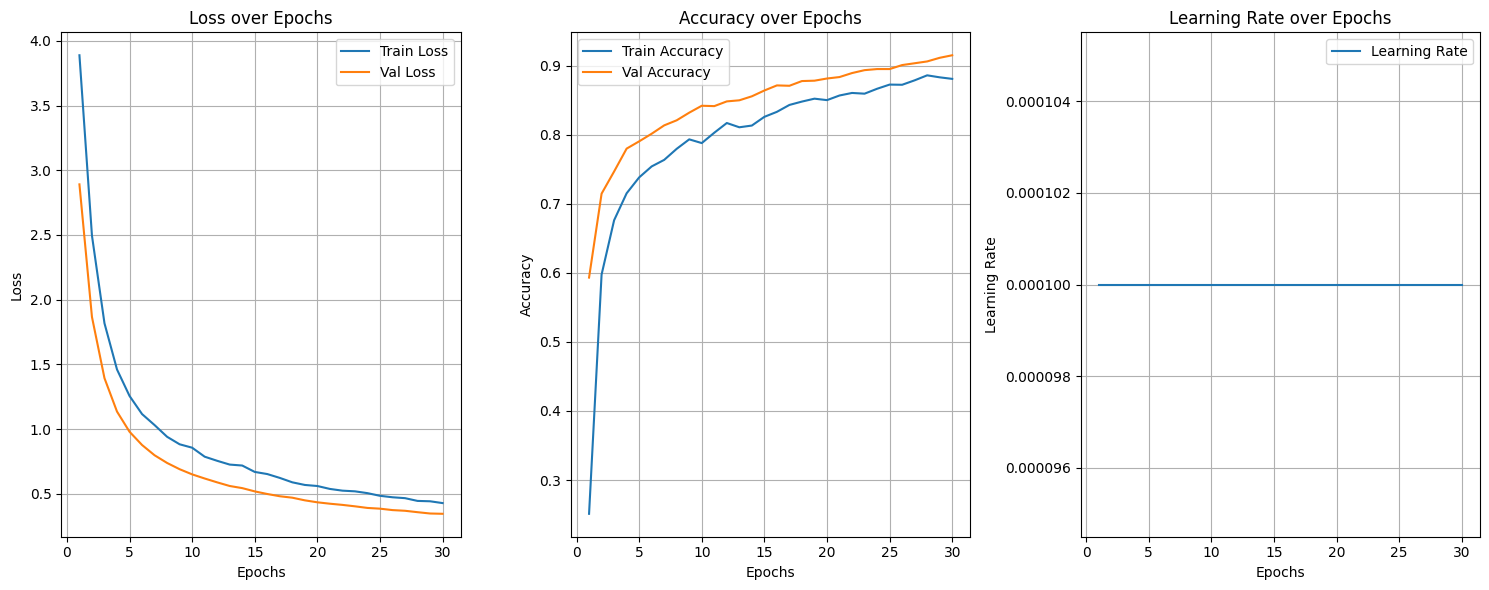

In [188]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
lr_history = []

num_epochs = 30
best_val_loss = float('inf')
patience = 3
patience_counter = 0

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    model.train() 
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  
        
        # Прямой проход
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 
        loss = criterion(outputs, labels) 
        
        loss.backward() 
        optimizer.step()  
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    
    model.eval() 
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad(): 
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    
    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
    
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())
    
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    
    if val_epoch_loss < best_val_loss: 
        best_val_loss = val_epoch_loss
        best_model_wts = model.state_dict()  
        patience_counter = 0 
    else:
        patience_counter += 1  
        if patience_counter >= patience: 
            print("Early stopping triggered.")
            break  # Прерываем обучение

    # Шаг scheduler-а
    lr_scheduler.step(val_epoch_loss)
    lr_history.append(optimizer.param_groups[0]['lr'])
    
model.load_state_dict(best_model_wts)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

ax3.plot(range(1, len(lr_history) + 1), lr_history, label='Learning Rate')
ax3.set_title('Learning Rate over Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Learning Rate')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

Ситуация улучшилась, тут и accuracy лучше и loss намного меньше. А что насчёт генератора???

## 4. Генератор GAN 

In [317]:
dimension = 100
image_shape = (3, 32, 32)
batch_size = 32
num_epochs = 100
display_after = 10
save_path = 'gen_images'
os.makedirs(save_path, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [318]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(True),
            nn.Unflatten(1, (128, 8, 8)),  # (B, 128, 8, 8)

            nn.Upsample(scale_factor=2),  # -> 16x16
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(True),

            nn.Upsample(scale_factor=2),  # -> 32x32
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(True),

            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()  # [-1, 1]
        )

    def forward(self, z):
        return self.model(z)


In [319]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ZeroPad2d((0,1,0,1)),
            nn.BatchNorm2d(64, momentum=0.82),
            nn.LeakyReLU(0.25, inplace=True),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128, momentum=0.82),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.8),
            nn.LeakyReLU(0.25, inplace=True),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 1),
            # nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)
    



In [320]:
def display_images(generator, epoch, latent_dim=dimension, n_row=5, n_col=5):
    generator.eval()
    noise = torch.randn(n_row * n_col, latent_dim, device=device)
    with torch.no_grad():
        gen_imgs = generator(noise).cpu()
    gen_imgs = 0.5 * (gen_imgs + 1)  # scale from [-1,1] to [0,1]

    fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*2, n_row*2))
    for i in range(n_row * n_col):
        img = gen_imgs[i].permute(1, 2, 0).numpy()
        axs[i // n_col, i % n_col].imshow(img)
        axs[i // n_col, i % n_col].axis('off')
    plt.tight_layout()
    plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()
    generator.train()

[Epoch 0] D loss: 0.7236, G loss: 0.7374


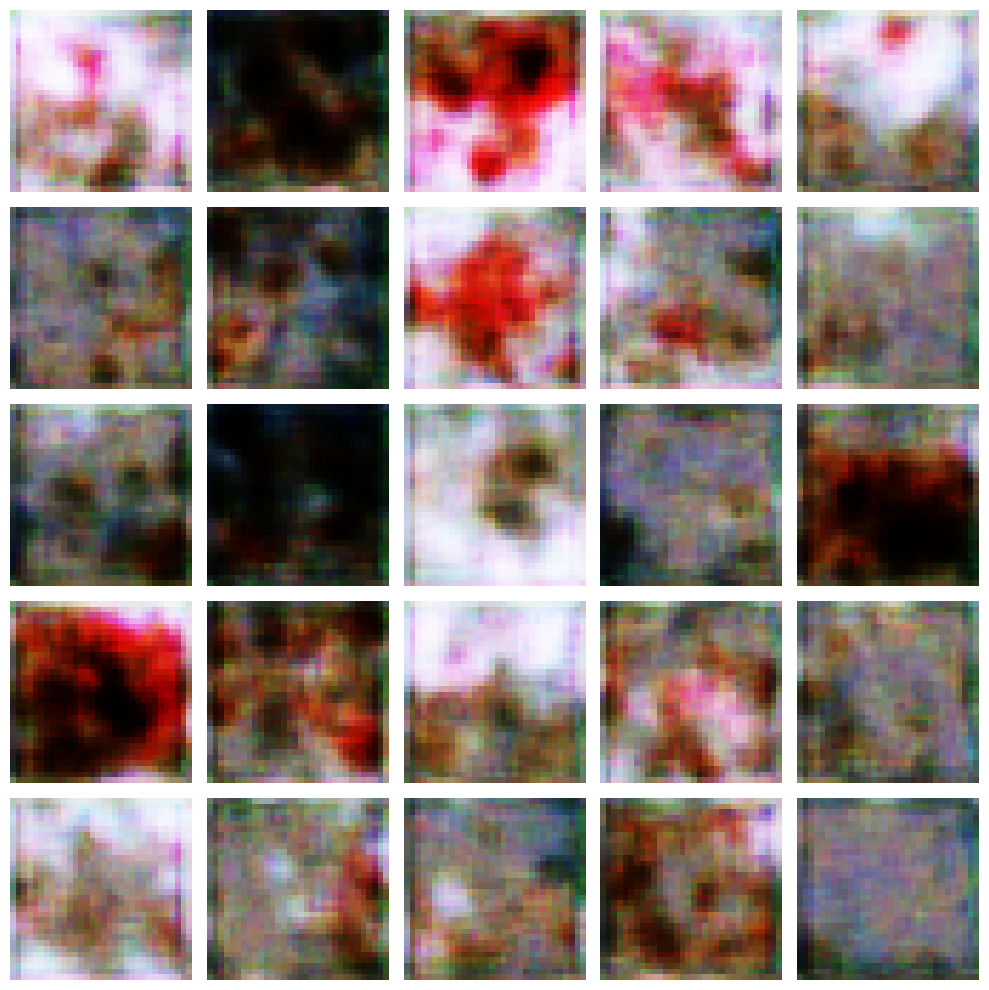

[Epoch 10] D loss: 0.6566, G loss: 0.5829


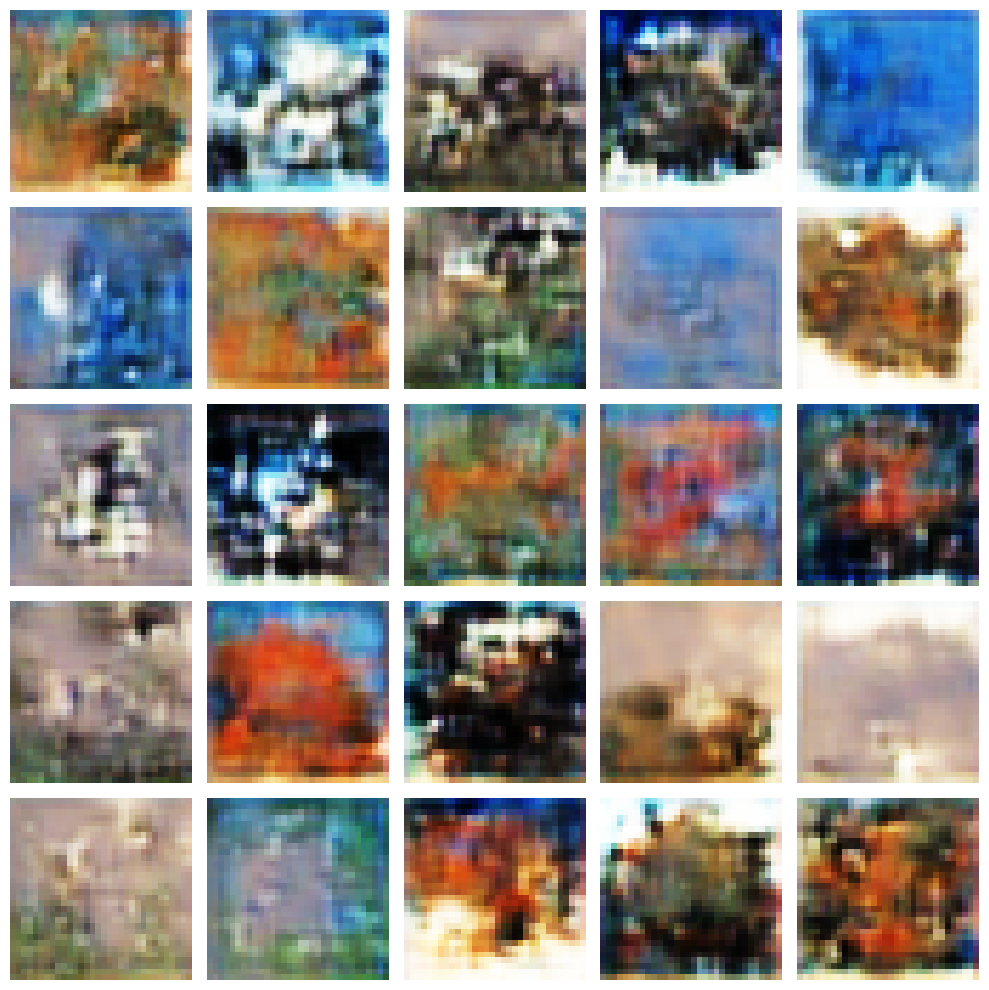

[Epoch 20] D loss: 0.5650, G loss: 1.4186


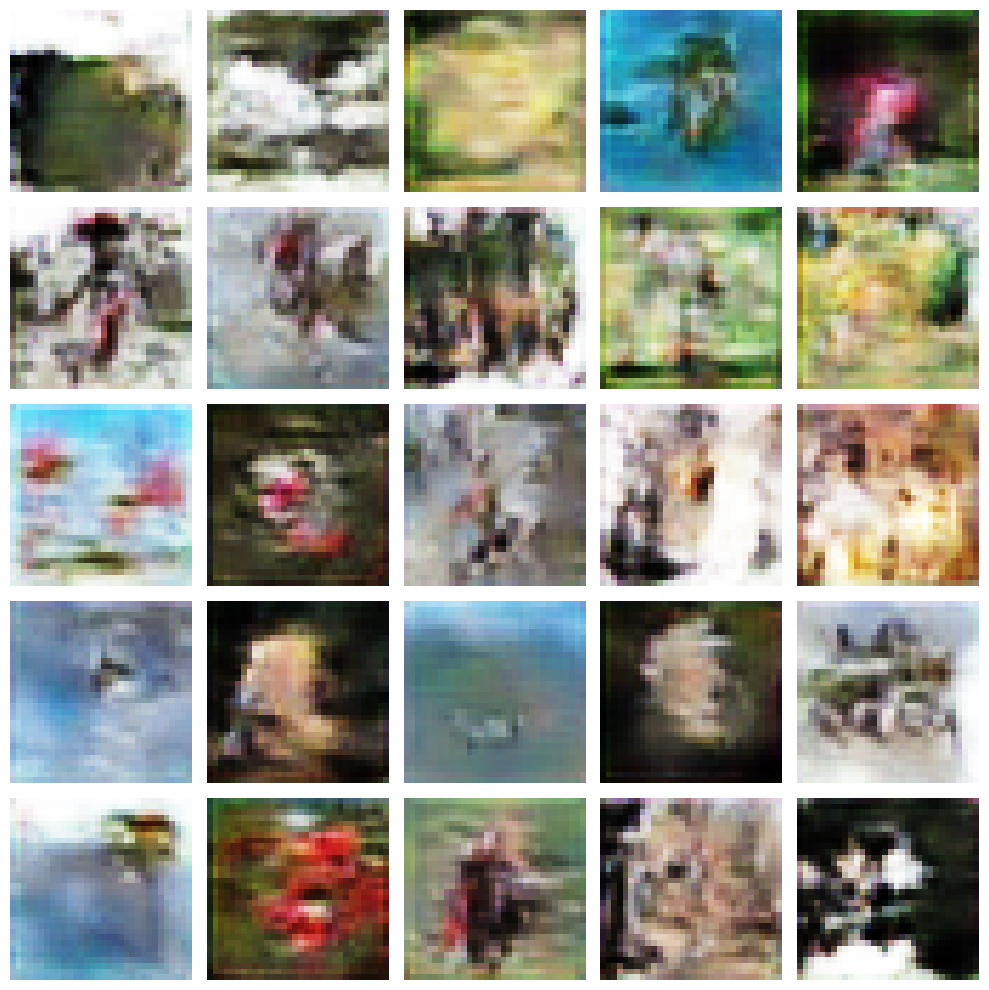

[Epoch 30] D loss: 0.4149, G loss: 1.6376


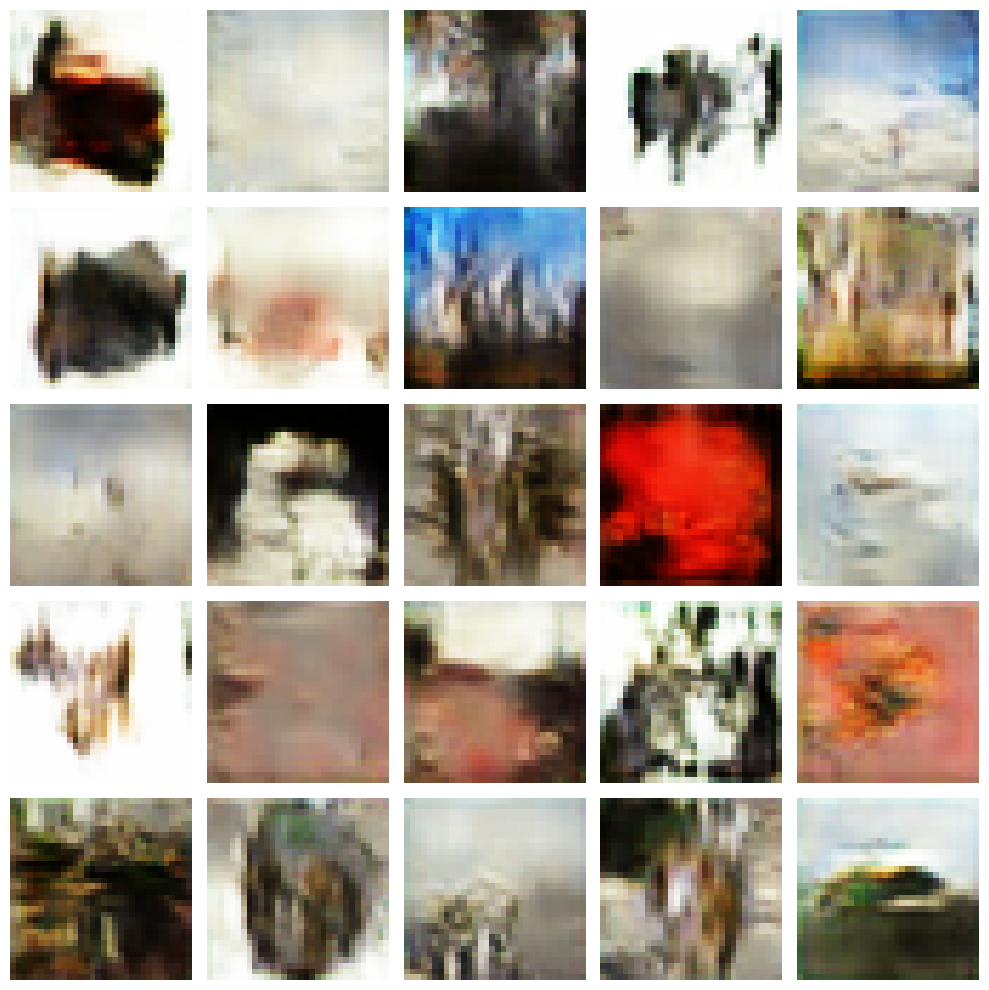

[Epoch 40] D loss: 0.6599, G loss: 1.1997


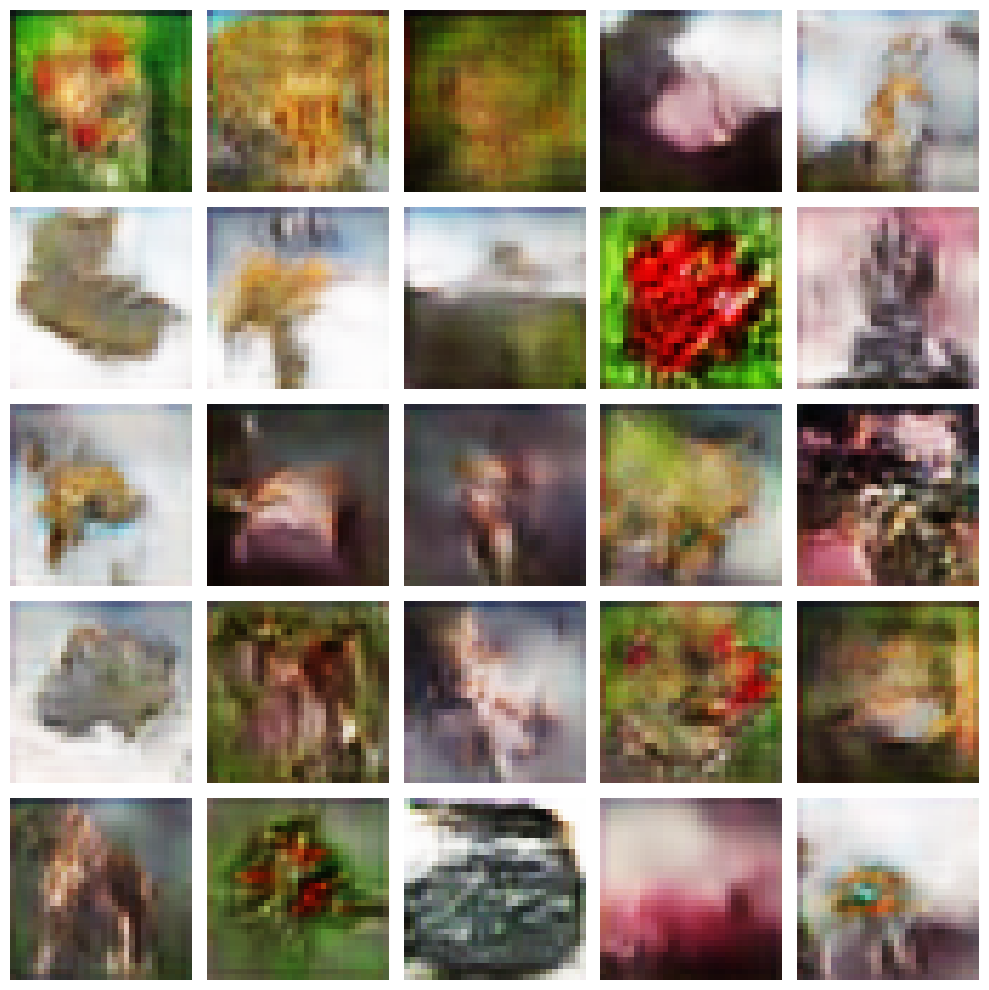

[Epoch 50] D loss: 0.6325, G loss: 0.8428


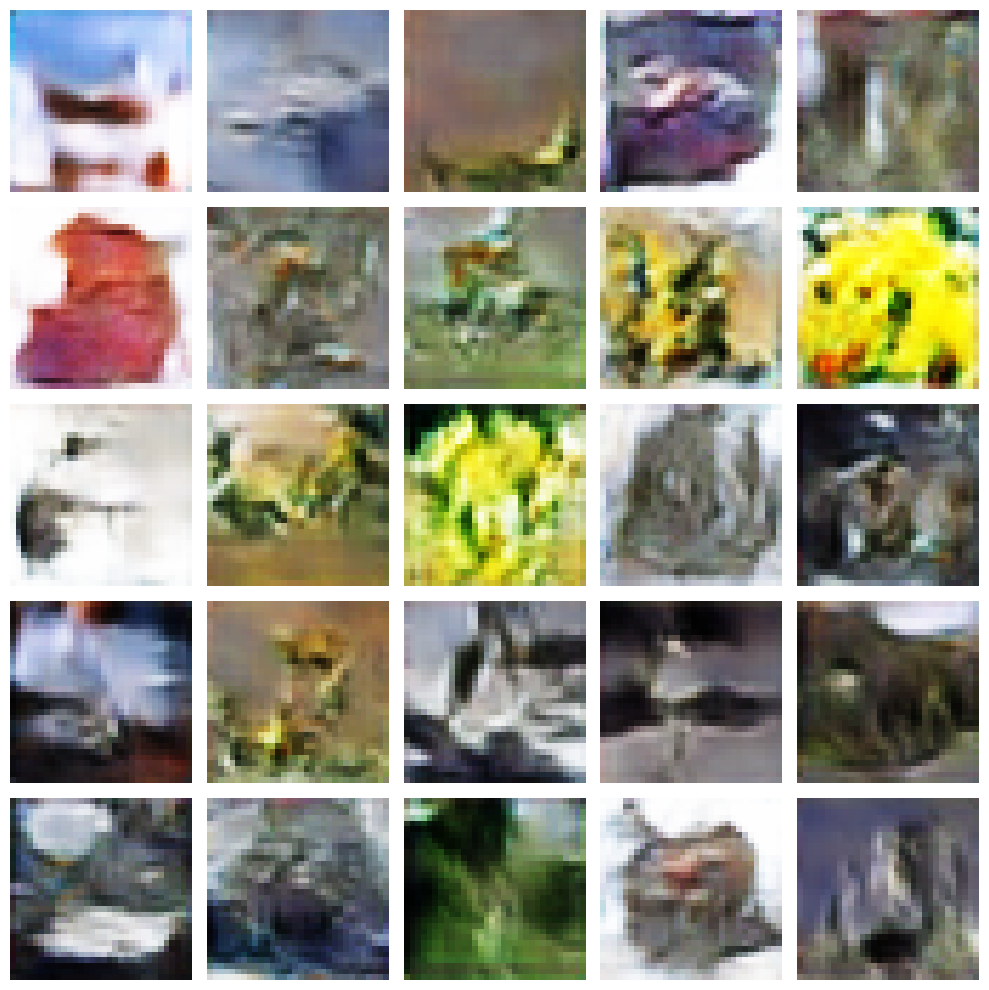

[Epoch 60] D loss: 0.5101, G loss: 1.8054


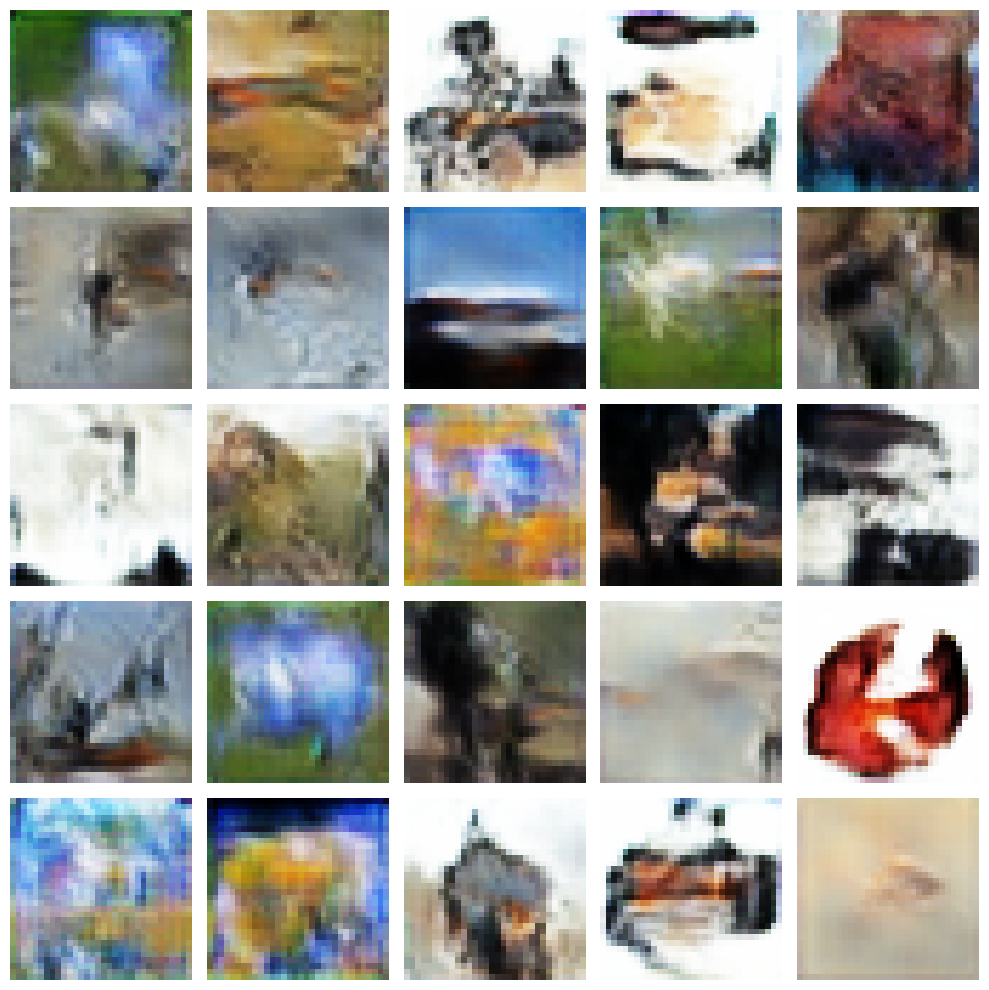

[Epoch 70] D loss: 0.1354, G loss: 1.5109


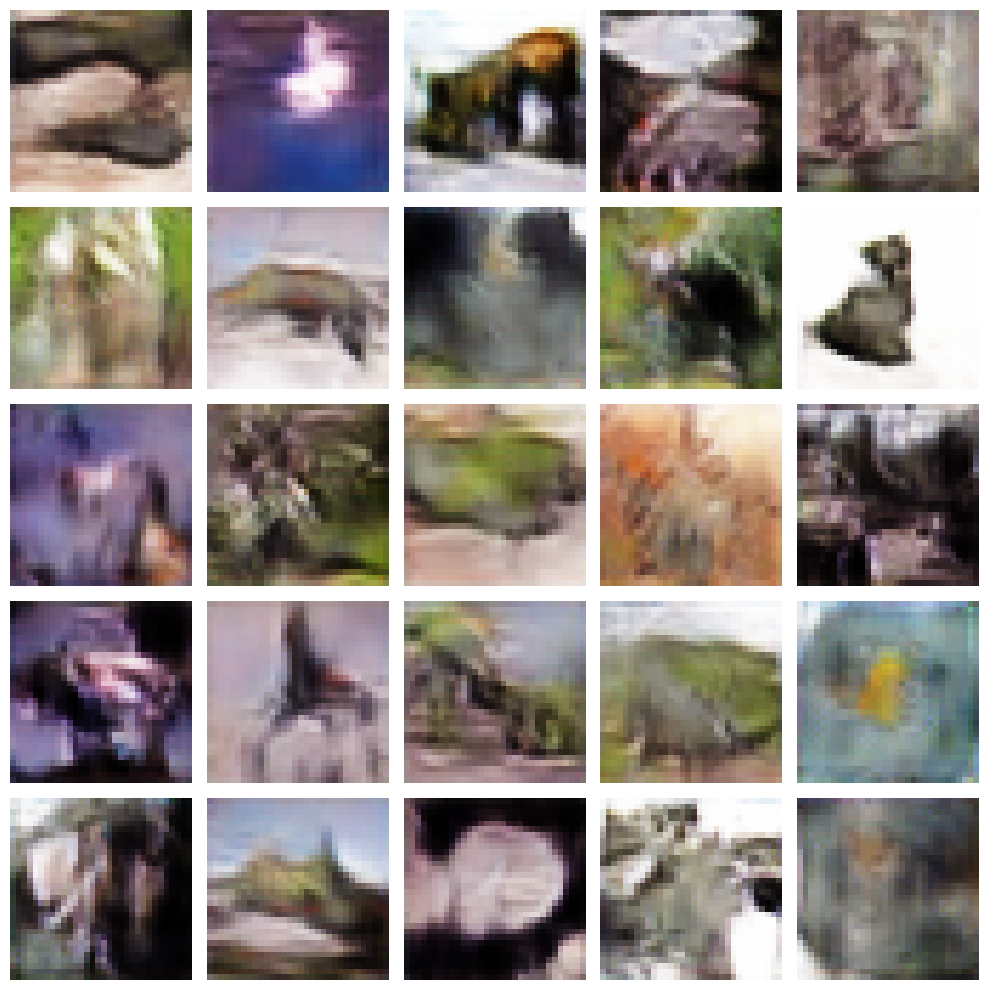

[Epoch 80] D loss: 0.7727, G loss: 1.0357


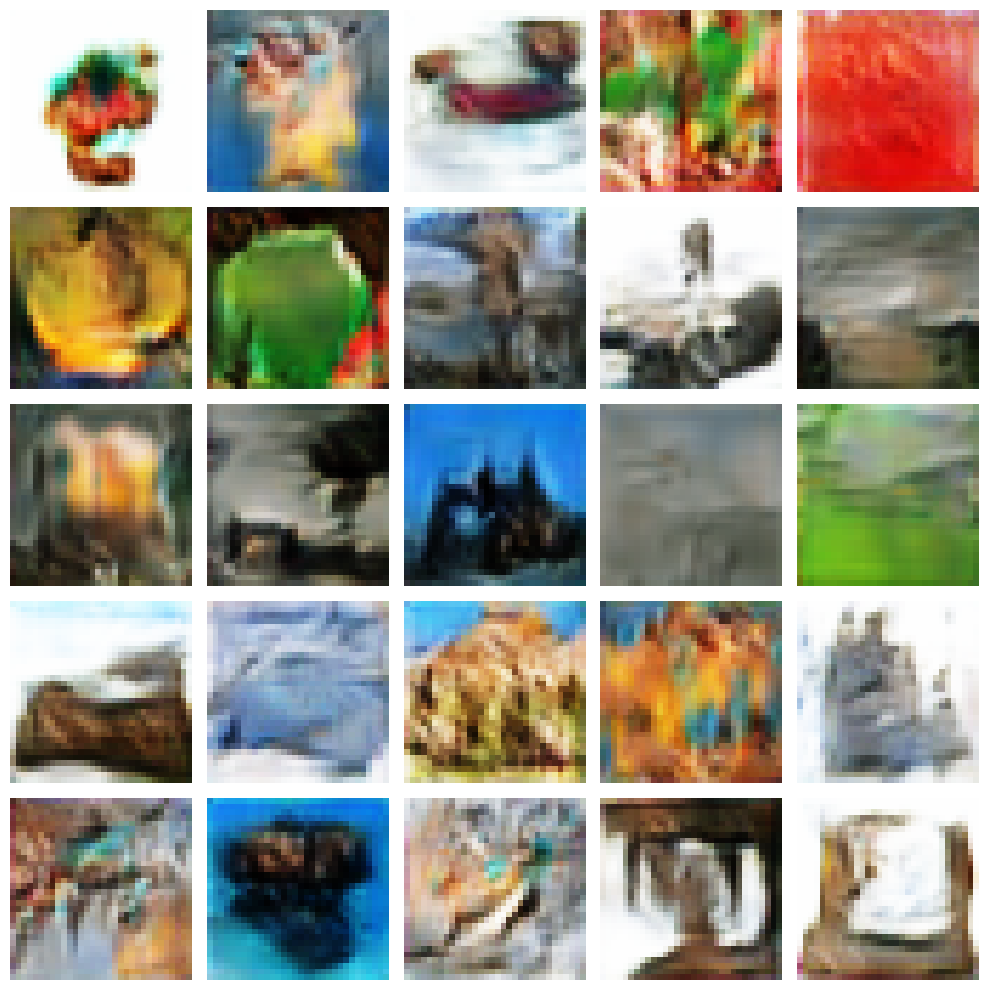

[Epoch 90] D loss: 0.3521, G loss: 2.3091


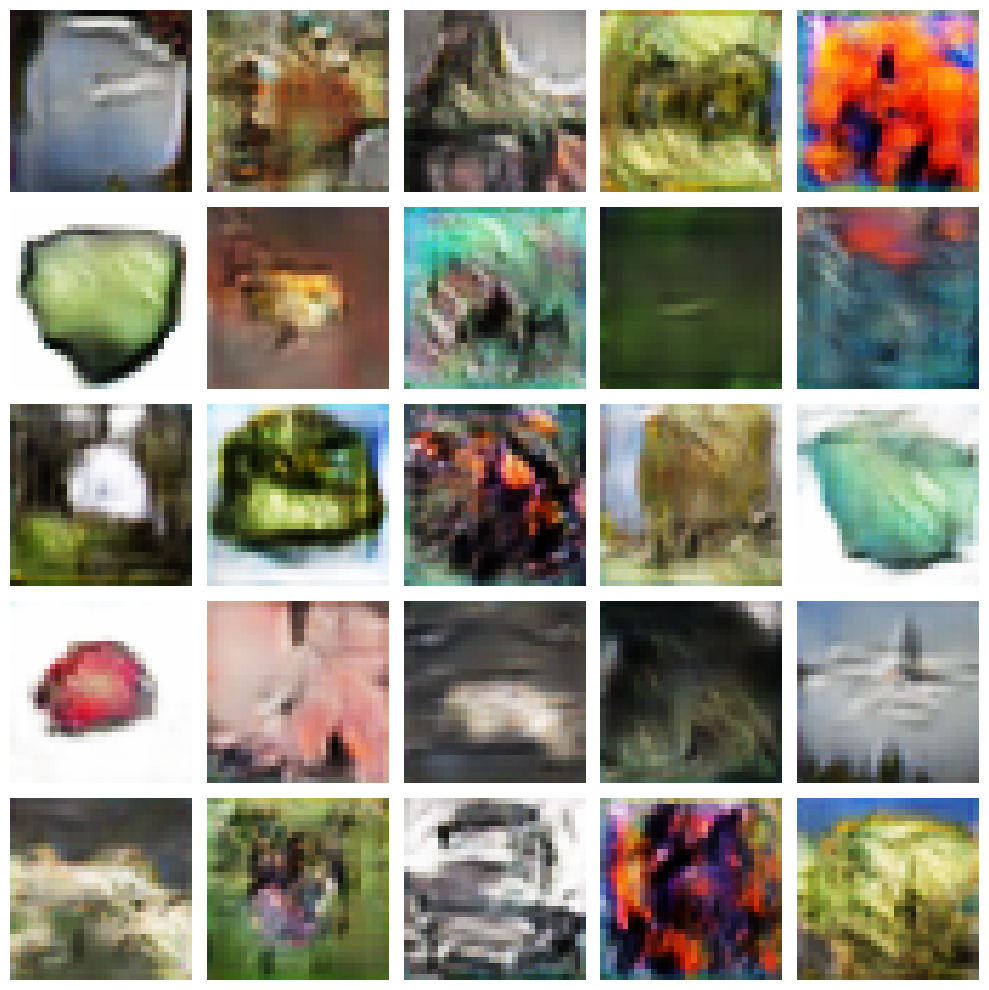

In [321]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # [-1, 1]
])

dataset = CustomGenerator(root_dir=root, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=True)

generator = Generator(dimension).to(device)
discriminator = Discriminator().to(device)

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

valid = torch.ones(batch_size, 1, device=device)
fake = torch.zeros(batch_size, 1, device=device)

for epoch in range(num_epochs):
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        real_valid = valid + 0.05 * torch.rand_like(valid)
        fake_valid = fake + 0.05 * torch.rand_like(fake)

        # === Обучение дискриминатора ===
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, dimension, device=device)
        gen_imgs = generator(z)
        d_loss_real = adversarial_loss(discriminator(imgs), real_valid)
        d_loss_fake = adversarial_loss(discriminator(gen_imgs.detach()), fake_valid)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        optimizer_D.step()

        # === Обучение генератора ===
        optimizer_G.zero_grad()
        g_loss = adversarial_loss(discriminator(gen_imgs), real_valid)
        g_loss.backward()
        optimizer_G.step()

    if epoch % display_after == 0:
        print(f"[Epoch {epoch}] D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")
        display_images(generator, epoch)


Получили что то странное, возможно, плохое качество даёт о себе знать или можно было бы посмотреть на большем количестве эпох. Кстати, с добавлением нагенерированных изображений качество модели не увеличивается, даже немного проседает. 

## Модель с лучшим score на Kaggle

In [274]:
train_dataset = MultiClassDataset(split="train", root_dir=root, transform=easy_transforms["train"])
val_dataset = MultiClassDataset(split="val", root_dir=root, transform=easy_transforms["test"])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [275]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [276]:
num_classes = len(train_dataset.class_to_idx)

class_weights = []
total_samples = sum(class_counts.values())
for i in range(num_classes):
    count = class_counts.get(i, 0)
    if count == 0:
        weight = 0
    else:
        weight = total_samples / (num_classes * count)
    class_weights.append(weight)

class_weights_tensor = torch.FloatTensor(class_weights).to(device)

In [277]:
class Image_100_2(nn.Module):
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        x = self.backbone.forward_features(x)
        cls_token = x[:, 0]
        x = self.head(cls_token)
        return x

In [278]:
backbone = timm.create_model("vit_large_patch16_224", pretrained=True, num_classes=0  )

for param in backbone.parameters():
    param.requires_grad = False

num_features = 1024

head = nn.Sequential(
    nn.LayerNorm(num_features),
    nn.Dropout(p=0.3),  # чуть сильнее регуляризация
    nn.Linear(num_features, 100)
)

model = Image_100_2(backbone, head)


In [279]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 1024, 14, 14]         787,456
          Identity-2            [-1, 196, 1024]               0
        PatchEmbed-3            [-1, 196, 1024]               0
           Dropout-4            [-1, 197, 1024]               0
          Identity-5            [-1, 197, 1024]               0
          Identity-6            [-1, 197, 1024]               0
         LayerNorm-7            [-1, 197, 1024]           2,048
            Linear-8            [-1, 197, 3072]       3,148,800
          Identity-9          [-1, 16, 197, 64]               0
         Identity-10          [-1, 16, 197, 64]               0
           Linear-11            [-1, 197, 1024]       1,049,600
          Dropout-12            [-1, 197, 1024]               0
        Attention-13            [-1, 197, 1024]               0
         Identity-14            [-1, 19

In [280]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/25
Train Loss: 4.0104, Train Acc: 0.2174
Val Loss: 2.9935, Val Acc: 0.6619
Epoch 2/25
Train Loss: 2.5882, Train Acc: 0.6375
Val Loss: 1.8404, Val Acc: 0.8139
Epoch 3/25
Train Loss: 1.7469, Train Acc: 0.7674
Val Loss: 1.2350, Val Acc: 0.8570
Epoch 4/25
Train Loss: 1.3043, Train Acc: 0.8017
Val Loss: 0.9217, Val Acc: 0.8749
Epoch 5/25
Train Loss: 1.0613, Train Acc: 0.8191
Val Loss: 0.7466, Val Acc: 0.8822
Epoch 6/25
Train Loss: 0.9099, Train Acc: 0.8335
Val Loss: 0.6364, Val Acc: 0.8891
Epoch 7/25
Train Loss: 0.8051, Train Acc: 0.8452
Val Loss: 0.5602, Val Acc: 0.8948
Epoch 8/25
Train Loss: 0.7353, Train Acc: 0.8488
Val Loss: 0.5048, Val Acc: 0.9022
Epoch 9/25
Train Loss: 0.6590, Train Acc: 0.8591
Val Loss: 0.4614, Val Acc: 0.9096
Epoch 10/25
Train Loss: 0.6288, Train Acc: 0.8636
Val Loss: 0.4266, Val Acc: 0.9132
Epoch 11/25
Train Loss: 0.6032, Train Acc: 0.8651
Val Loss: 0.3997, Val Acc: 0.9180
Epoch 12/25
Train Loss: 0.5586, Train Acc: 0.8743
Val Loss: 0.3751, Val Acc: 0.9190
E

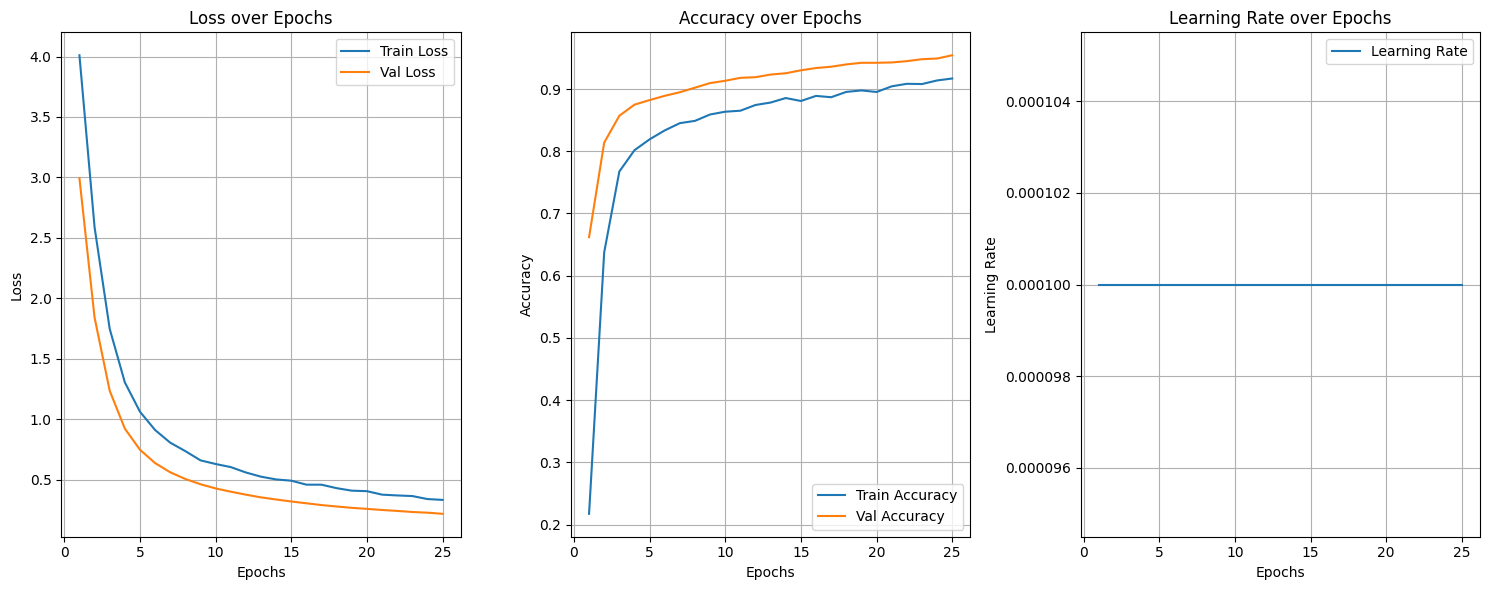

In [281]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
lr_history = []

num_epochs = 25
best_val_loss = float('inf')
patience = 3
patience_counter = 0

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, verbose=True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    model.train() 
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  
        
        # Прямой проход
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  
        loss = criterion(outputs, labels)  
        
        loss.backward()  
        optimizer.step() 
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    
    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    
    model.eval() 
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():  
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
    
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())
    
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    
    # === EARLY STOPPING ===
    if val_epoch_loss < best_val_loss:  
        best_val_loss = val_epoch_loss
        best_model_wts = model.state_dict() 
        patience_counter = 0 
    else:
        patience_counter += 1  
        if patience_counter >= patience:  
            print("Early stopping triggered.")
            break  # Прерываем обучение


    lr_scheduler.step(val_epoch_loss)
    lr_history.append(optimizer.param_groups[0]['lr'])

model.load_state_dict(best_model_wts)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6)) 


ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

ax3.plot(range(1, len(lr_history) + 1), lr_history, label='Learning Rate')
ax3.set_title('Learning Rate over Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Learning Rate')
ax3.legend()
ax3.grid(True)


plt.tight_layout()  
plt.show()


In [323]:
def predict_image(model, image_path, transform):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    transformed = transform(image=image) 
    image_tensor = transformed["image"].unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)
    return preds.item()

test_files = sorted([f for f in os.listdir(test_dir) if f.lower().endswith('.png')])

predictions = []
for filename in tqdm(test_files, desc="Предсказание"):
    try:
        img_path = os.path.join(test_dir, filename)
        file_id = os.path.splitext(filename)[0]

        pred_idx = predict_image(model, img_path, easy_transforms['train'])
        class_id = int(idx_to_class[pred_idx]) 

        predictions.append({'id': file_id, 'target': class_id})
    except Exception as e:
        print(f"Ошибка при обработке {filename}: {str(e)}")
        predictions.append({'id': os.path.splitext(filename)[0], 'target': -1})
results_df = pd.DataFrame(predictions)
results_df['id_num'] = results_df['id'].str.extract('(\d+)').astype(int)
results_df = results_df.sort_values('id_num').drop('id_num', axis=1).reset_index(drop=True)

results_df.to_csv('best.csv', index=False)
print(results_df.head())

Предсказание: 100%|██████████| 3878/3878 [01:31<00:00, 42.23it/s]

  id  target
0  0      71
1  1      62
2  2      18
3  3      41
4  4      66
